=== Cross-Validation Results (5-fold) ===
Average Precision: 0.185 ± 0.028
F1 Score:         0.158 ± 0.016
ROC-AUC:          0.851 ± 0.029

=== Test Set Results (Threshold = 0.95) ===
              precision    recall  f1-score   support

           0      0.969     0.994     0.981      1259
           1      0.200     0.048     0.077        42

    accuracy                          0.963      1301
   macro avg      0.585     0.521     0.529      1301
weighted avg      0.944     0.963     0.952      1301

Confusion Matrix:
 [[1251    8]
 [  40    2]]
Weighted Average Precision (Threshold = 0.95): 0.944

=== Test Set Results (Threshold = 0.7) ===
              precision    recall  f1-score   support

           0      0.978     0.871     0.921      1259
           1      0.095     0.405     0.154        42

    accuracy                          0.856      1301
   macro avg      0.536     0.638     0.538      1301
weighted avg      0.949     0.856     0.897      1301

Confusion Matrix:
 

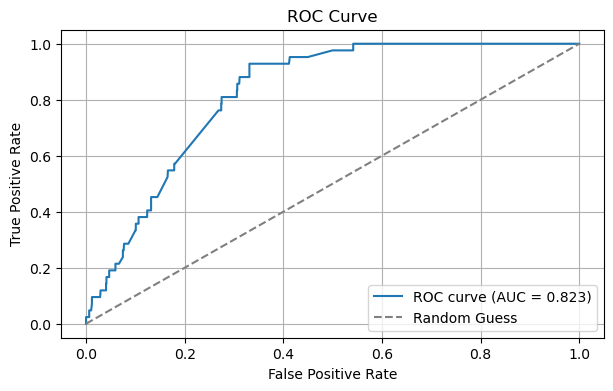

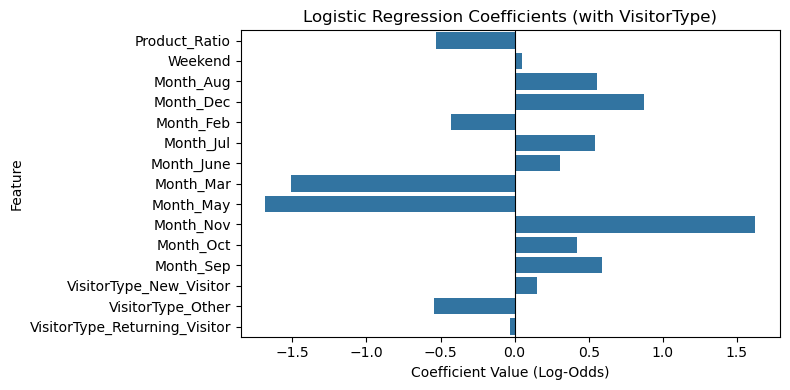

Feature coefficients (log-odds):
Month_May                       -1.682255
Month_Mar                       -1.507994
VisitorType_Other               -0.544459
Product_Ratio                   -0.530722
Month_Feb                       -0.427063
VisitorType_Returning_Visitor   -0.030451
Weekend                          0.052337
VisitorType_New_Visitor          0.149210
Month_June                       0.306243
Month_Oct                        0.420954
Month_Jul                        0.544064
Month_Aug                        0.554086
Month_Sep                        0.588912
Month_Dec                        0.872589
Month_Nov                        1.625350
dtype: float64


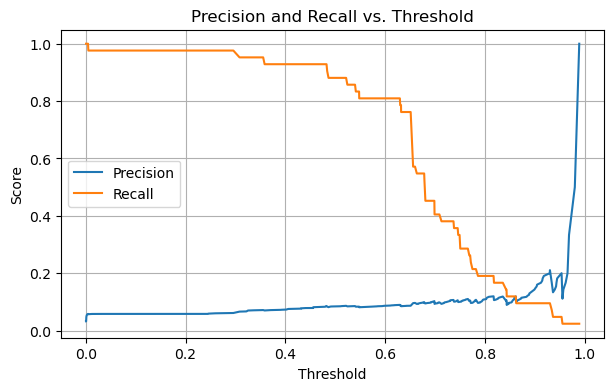

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, auc , roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('online_shoppers_enriched_V4.csv')

df = pd.get_dummies(df, columns=['VisitorType', 'Month'], drop_first=False)

features = ['Product_Ratio', 'Weekend'] + \
           [col for col in df.columns if col.startswith('Month_')] + \
           [col for col in df.columns if col.startswith('VisitorType_')]
X = df[features]
y = df['Revenue'].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

logreg = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_ap = cross_val_score(logreg, X_scaled, y, cv=cv, scoring='average_precision')
cv_f1 = cross_val_score(logreg, X_scaled, y, cv=cv, scoring='f1')
cv_roc = cross_val_score(logreg, X_scaled, y, cv=cv, scoring='roc_auc')

print("=== Cross-Validation Results (5-fold) ===")
print(f"Average Precision: {cv_ap.mean():.3f} ± {cv_ap.std():.3f}")
print(f"F1 Score:         {cv_f1.mean():.3f} ± {cv_f1.std():.3f}")
print(f"ROC-AUC:          {cv_roc.mean():.3f} ± {cv_roc.std():.3f}")

logreg.fit(X_train, y_train)
y_prob = logreg.predict_proba(X_test)[:, 1]

# Custom threshold prediction
for threshold in [0.95, 0.7,0.55, 0.5, 0.3, 0.2,0.1]:
    y_pred_thresh = (y_prob >= threshold).astype(int)
    print(f"\n=== Test Set Results (Threshold = {threshold}) ===")
    print(classification_report(y_test, y_pred_thresh, digits=3))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))
    report = classification_report(y_test, y_pred_thresh, output_dict=True)
    weighted_avg_precision = report['weighted avg']['precision']
    print(f"Weighted Average Precision (Threshold = {threshold}): {weighted_avg_precision:.3f}")

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

coeffs = pd.Series(logreg.coef_[0], index=X.columns)
plt.figure(figsize=(8,4))
sns.barplot(x=coeffs.values, y=coeffs.index)
plt.title('Logistic Regression Coefficients (with VisitorType)')
plt.xlabel('Coefficient Value (Log-Odds)')
plt.ylabel('Feature')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()
print("Feature coefficients (log-odds):")
print(coeffs.sort_values())

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(7,4))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid()
plt.show()
